# Regressao

[**House Prices:** Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from subprocess import call
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import KFold
import sklearn as sk 
from numpy import random
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image
import os
pd.options.display.max_rows = 2000
%matplotlib inline

In [2]:
df = pd.read_csv(os.path.join(os.path.abspath(''), "data/train.csv"))
df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

# Analisando correlacoes

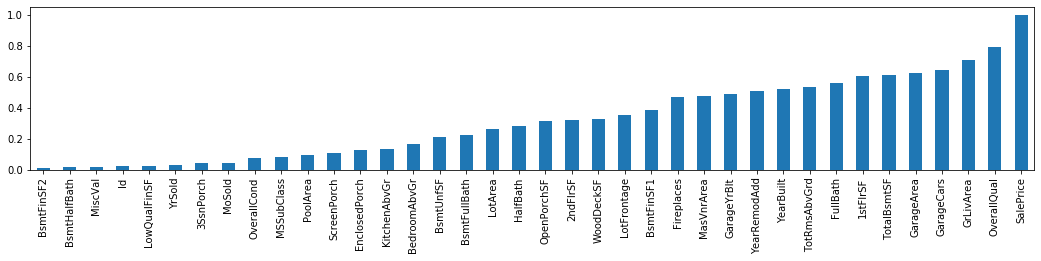

In [3]:
df.corr().abs()["SalePrice"].sort_values().plot.bar(figsize=[18, 3])

Dado o numero de colunas, alguns pares de atributos podem ser redudantes, isso normalmente se manifesta como uma alta correlacao entre dois atributos quaisquer. Podemos tentar identificar esses pares e simplificar o dataset atraves da remocao de um de seus componentes.

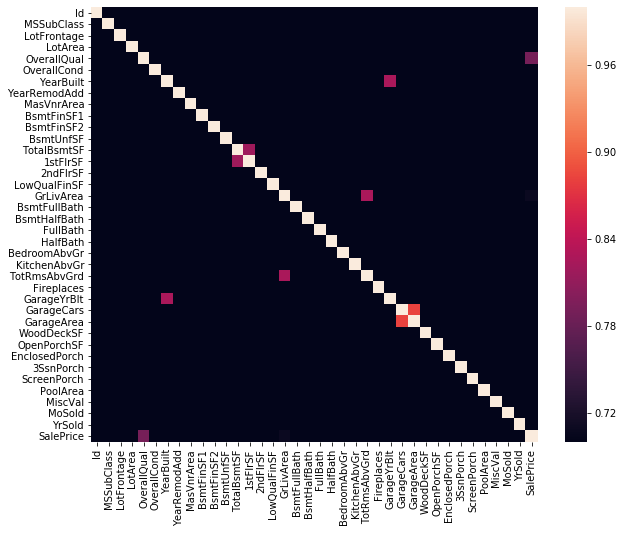

In [4]:
plt.figure(figsize=[10,8])
sns.heatmap(df.corr(), vmin=0.7)

`GarageYrBlt` e `GarageArea` serao descartados, pois possuem correlacao maior que 80% com outros atributos - `YearBlt` e `GarageCars`, respectivamente.

`TotRmsAbvGrd` tambem sera descartado, pois de certa forma sua informacao ja esta contida em `GrLivArea`.

In [5]:
df.drop(columns=["GarageYrBlt", "GarageArea", "TotRmsAbvGrd"], inplace=True)

Atributos que possuem correlacao muito baixa com preco de venda tambem serao descartados

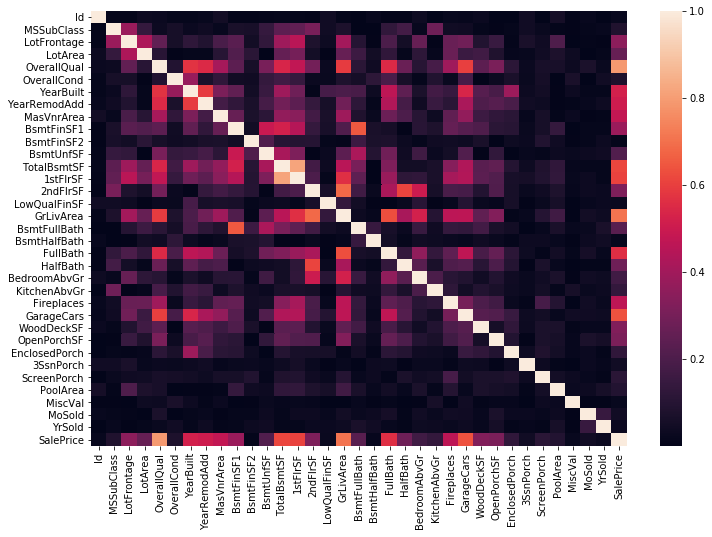

In [6]:
plt.figure(figsize=[12,8])
sns.heatmap(df.corr().abs())

In [7]:
df.drop(columns=["Id", "BsmtFinSF2", "LowQualFinSF", "BsmtHalfBath", "3SsnPorch", "MiscVal", "YrSold", "MoSold"], inplace=True)

## Identificando dados faltando 

In [8]:
missing = df.isna().mean()
missing[missing.gt(0)] * 100

LotFrontage     17.739726
Alley           93.767123
MasVnrType       0.547945
MasVnrArea       0.547945
BsmtQual         2.534247
BsmtCond         2.534247
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtFinType2     2.602740
Electrical       0.068493
FireplaceQu     47.260274
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
PoolQC          99.520548
Fence           80.753425
MiscFeature     96.301370
dtype: float64

### Sobre o porão

- A maiora dos atributos Bsmt.* - relacionados a porão - possuem a mesma taxa de dados faltando, pois implicitamente estao relacionados a ideia da casa ter ou nao porão.

- O atributo `TotalBsmtSF` indica a area do porao.

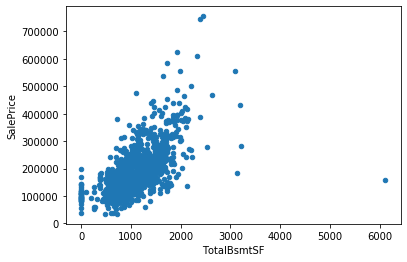

In [9]:
df[["SalePrice", "TotalBsmtSF"]].plot.scatter(x="TotalBsmtSF", y="SalePrice")

- Existe uma correlacao quase linear entre `TotalBsmtSF` e `SalePrice` para `TotalBsmtSF` maiores que 0

Para simplificar o dataset descartaremos todas as colunas relacionadas a porão com excecao de sua area, podemos entao criar um atributo binario `PossuiPorao`, pois faz sentido que na decisao da compra de uma casa a o tamanho seja o atributo mais importante relacionado a porao.

In [10]:
df.drop(columns=["BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2"], inplace=True)

### Sobre garagens

- De forma analoga a poroes, os atributos Garage.* possuem as mesmas taxas de dados faltando, pois estao relacionados a existencia da garagem.
- GarageCars diz respeito a quantidade de vagas na garagem

Serao descartados os atributos relacionados a garagem, com excecao do `GarageCars`, pois na decisao da compra de uma casa faz sentido que esse seja o atributo mais importante relacionado a garagem.

In [11]:
df.drop(columns=["GarageType","GarageFinish","GarageQual","GarageCond"], inplace=True)

### LotFrontage

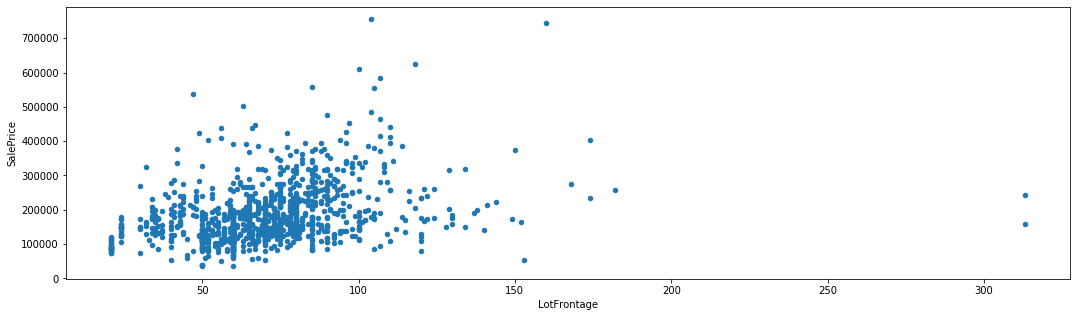

In [12]:
df[["SalePrice", "LotFrontage"]].plot.scatter(y="SalePrice", x="LotFrontage", figsize=[18, 5])

Com presenca de outliers, 17% das instancias faltando e correlacao nao muito alta com `SalePrice`, podemos descartar o atributo `LotFrontage`

In [13]:
df.drop(columns=["LotFrontage"], inplace=True)

### Alley
Type of alley access
- Grvl: Gravel
- Pave: Paved
- NA:   No alley access

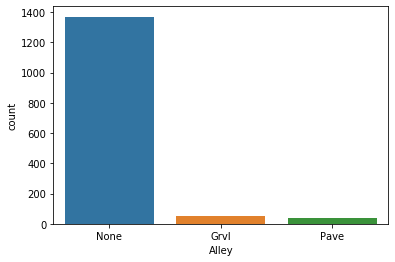

In [14]:
df["Alley"].fillna("None", inplace=True)
sns.countplot(df["Alley"])

Como esse atributo esta muito desbalanceado, descarta-lo sera a alternativa mais simples

In [15]:
df.drop(columns=["Alley"], inplace=True)

### MasVnrType
Masonry veneer type

- BrkCmn: Brick Common
- BrkFace: Brick Face
- CBlock: Cinder Block
- None: None
- Stone: Stone

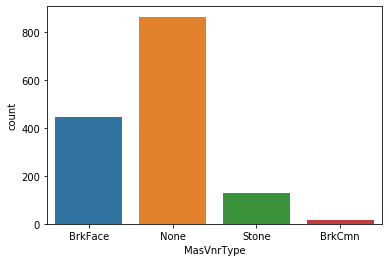

In [16]:
sns.countplot(df["MasVnrType"])

Como esse atributo esta muito desbalanceado, descarta-lo sera a alternativa mais simples

In [17]:
df.drop(columns=["MasVnrType"], inplace=True)

### MasVnrArea

In [18]:
df["MasVnrArea"].isna().mean()

0.005479452054794521

Como menos de 1% das instancias possuem esse dado faltando, podemos descartar tais instancias

In [19]:
df["MasVnrArea"].dropna(inplace=True)

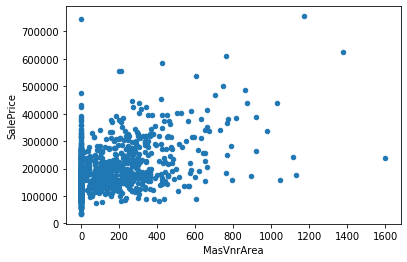

In [20]:
df[["SalePrice", "MasVnrArea"]].plot.scatter(x="MasVnrArea", y="SalePrice")

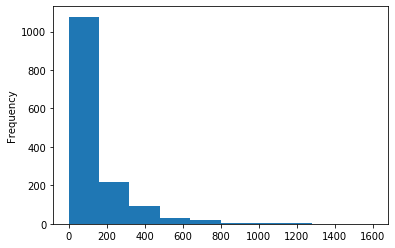

In [21]:
df["MasVnrArea"].plot.hist()

Dado o numero multo alto de outliers e ao desbalanceamento desse atributo, nossa vida sera mais simples o descartando.

In [22]:
df.drop(columns=["MasVnrArea"], inplace=True)

### Electrical
- SBrkr:    Standard Circuit Breakers & Romex
- FuseA:    Fuse Box over 60 AMP and all Romex wiring (Average) 
- FuseF:    60 AMP Fuse Box and mostly Romex wiring (Fair)
- FuseP:    60 AMP Fuse Box and mostly knob & tube wiring (poor)
- Mix:  Mixed

Esse atributo e muito especifico e pode resultar em super-ajustamento, podemos optar por descarta-lo


In [23]:
df.drop(columns=["Electrical"], inplace=True)

### MiscFeature
Pelo mesmo motivo de Eletrical, esse atributo sera descartado

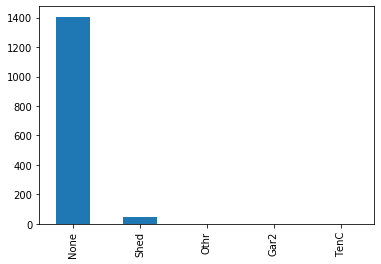

In [24]:
df["MiscFeature"].fillna("None").value_counts().plot.bar()

In [25]:
df.drop(columns=["MiscFeature"], inplace=True)

### FireplaceQu
Senso comum diz que a informacao mais valiosa nesse atributo e o fato de existir ou nao a lareira, e nao necessariamente sua qualidade - atributo desbalanceado -, o que ja esta codificado em `Fireplaces`, que indica a quantidade de lareiras na casa.

In [26]:
df.drop(columns=["FireplaceQu"], inplace=True)

### PoolQC

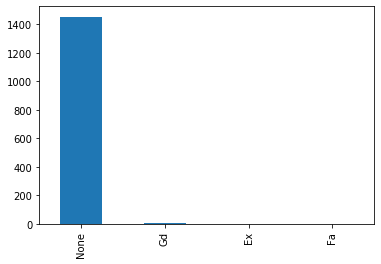

In [27]:
df["PoolQC"].fillna("None").value_counts().plot.bar()

Atributo muito desbalanceado, logo tambem sera descartado

In [28]:
df.drop(columns=["PoolQC"], inplace=True)

### Fence

Tambem sera descartado por desbalanceamento e baixa relevancia na decisao de comprar uma casa

In [29]:
df.assign(Fence=df["Fence"].fillna("None"))[["Fence", "SalePrice"]].groupby("Fence").describe()

SalePrice                                                             \
          count           mean           std       min       25%       50%   
Fence                                                                        
GdPrv      59.0  178927.457627  56757.237563  108000.0  144950.0  167500.0   
GdWo       54.0  140379.314815  53592.585059   34900.0  118625.0  138750.0   
MnPrv     157.0  148751.089172  66096.069463   40000.0  119900.0  137450.0   
MnWw       11.0  134286.363636  21781.805376  110000.0  121500.0  130000.0   
None     1179.0  187596.837998  81656.497075   35311.0  132750.0  173000.0   

                           
            75%       max  
Fence                      
GdPrv  189475.0  475000.0  
GdWo   151750.0  381000.0  
MnPrv  158000.0  745000.0  
MnWw   143000.0  187000.0  
None   224700.0  755000.0

In [30]:
df.drop(columns=["Fence"], inplace=True)

### Verificando se ainda existem atributos faltando

In [31]:
missing = df.isna().mean()
missing[missing.gt(0)]

Series([], dtype: float64)

### Listando atributos nao numericos

In [32]:
non_numeric_attrs = df.select_dtypes("object").columns.values
print(non_numeric_attrs)

['MSZoning' 'Street' 'LotShape' 'LandContour' 'Utilities' 'LotConfig'
 'LandSlope' 'Neighborhood' 'Condition1' 'Condition2' 'BldgType'
 'HouseStyle' 'RoofStyle' 'RoofMatl' 'Exterior1st' 'Exterior2nd'
 'ExterQual' 'ExterCond' 'Foundation' 'Heating' 'HeatingQC' 'CentralAir'
 'KitchenQual' 'Functional' 'PavedDrive' 'SaleType' 'SaleCondition']


### Preenchendo NaN com categoria "None"

In [33]:
df[non_numeric_attrs] = df[non_numeric_attrs].fillna("None")

## Scaling e encoding dos atributos

Os atributos numericos - preco de venda, area das garagens etc - pertecem a intervalos diferentes; para que a maioria dos algoritmos de aprendizagem de maquina funcionem como esperado deve ser realizada normalizacao desses atributos de forma que todos passem a pertencer a um mesmo intervalo. Para isso sera utilizado o **MinMaxScaler**

Atributos categoricos serao transformados em numericos atraves de one-hot-encoding, que consiste em explodir uma coluna que tem N possiveis valores em N colunas binarias.

In [34]:
# Esses features serao transformados com one-hot-encoding
categorical_features = df.select_dtypes("object").columns.values

# Esses features serao tratados com MinMaxScaler
numeric_features = df.select_dtypes("int64").columns.values

In [35]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()

df_scaled = pd.concat([
    pd.get_dummies(df[categorical_features]), 
    pd.DataFrame(scaler.fit_transform(df[numeric_features]), columns=numeric_features)],
    axis=1)

In [36]:
df_scaled.head(3)

MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  \
0                 0            0            0            1            0   
1                 0            0            0            1            0   
2                 0            0            0            1            0   

   Street_Grvl  Street_Pave  LotShape_IR1  LotShape_IR2  LotShape_IR3  ...  \
0            0            1             0             0             0  ...   
1            0            1             0             0             0  ...   
2            0            1             1             0             0  ...   

   BedroomAbvGr  KitchenAbvGr  Fireplaces  GarageCars  WoodDeckSF  \
0      0.163779     -0.211454   -0.951226    0.311725   -0.752176   
1      0.163779     -0.211454    0.600495    0.311725    1.626195   
2      0.163779     -0.211454    0.600495    0.311725   -0.752176   

   OpenPorchSF  EnclosedPorch  ScreenPorch  PoolArea  SalePrice  
0     0.216503      -0.359325    -0.270208 -0.068692   0.347273  
1    -0.704483      -0.359325    -0.270208 -0.068692   0.007288  
2    -0.070361      -0.359325    -0.270208 -0.068692   0.536154  

[3 rows x 207 columns]

Todos os atributos agora estao numericos

## Predicao com MLP

O Multilayer Perceptron e uma das redes neurais mais simples e consegue aproximar funcoes nao-lineares arbritrarias, agora que temos os dados normalizados e encodificados podemos usar dessa rede para realizar a regressao.

In [44]:
df_train, df_test = sk.model_selection.train_test_split(df_scaled, test_size=0.2, shuffle=True)

mlp = MLPRegressor(learning_rate="adaptive", max_iter=300)

mlp.fit(df_train.drop("SalePrice", axis=1), df_train["SalePrice"])

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='adaptive',
             learning_rate_init=0.001, max_iter=300, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

### Resultado R2

In [45]:
y_predicted = mlp.predict(df_test.drop("SalePrice", axis=1))
y_true = df_test["SalePrice"]

sk.metrics.r2_score(y_true, y_predicted)

0.900495682124714

In [46]:
data = {
    "Real": pd.DataFrame(scaler.inverse_transform(df_test[numeric_features]), columns=numeric_features)["SalePrice"],
    "Estimado": pd.DataFrame(
        scaler.inverse_transform(
            df_test.assign(
                SalePrice=mlp.predict(df_test.drop("SalePrice", axis=1))
            )[numeric_features]), columns=numeric_features)["SalePrice"]
}

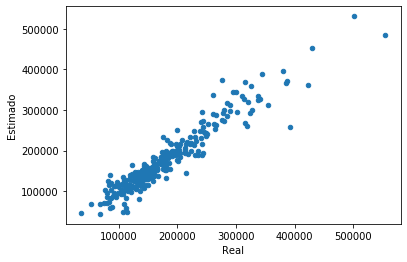

In [47]:
real_estimado = pd.DataFrame(data=data)
real_estimado.plot.scatter(x="Real", y="Estimado")

## Predicao com KNNRegressor 

Outro metodo simples mas efetivo para regressao

In [48]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor

nnr = KNeighborsRegressor(n_neighbors=2)
nnr.fit(df_train.drop("SalePrice", axis=1), df_train["SalePrice"]) 

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

### Resultado R2

In [49]:
y_predicted = nnr.predict(df_test.drop("SalePrice", axis=1))
y_true = df_test["SalePrice"]

sk.metrics.r2_score(y_true, y_predicted)

0.8463376129438689

### Otimizando o parametro numero de vizinhos

In [50]:
values = []
for i in np.arange(3,30, 2):
    #Para cada n_neighbors impar entre 3 e 30, guarde em values o valor medio do r2 ao longo de 5 ciclos
    average = None
    
    for j in range(0,5):
        nnr = KNeighborsRegressor(n_neighbors=i)
        nnr.fit(df_train.drop("SalePrice", axis=1), df_train["SalePrice"]) 
        y_predicted = nnr.predict(df_test.drop("SalePrice", axis=1))
        y_true = df_test["SalePrice"]
        r2 = sk.metrics.r2_score(y_true, y_predicted)
        average = r2 if average == None else (average + r2) / 2
        
        
    values.append({
        "k": i,
        "score": average
    })

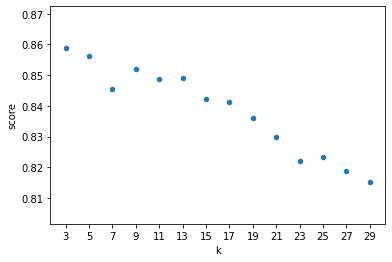

In [51]:
pd.DataFrame(values).plot.scatter(x="k",y="score", xticks=np.arange(3,30, 2))

O melhor resultado aconteceu para K=3.

**PS**: Confesso que essa curva nao e o que eu esperava e que isso deve ser um indicio de que ha algo muito errado em algum lugar

In [52]:
nnr = KNeighborsRegressor(n_neighbors=3)
nnr.fit(df_train.drop("SalePrice", axis=1), df_train["SalePrice"]) 

y_predicted = nnr.predict(df_test.drop("SalePrice", axis=1))
y_true = df_test["SalePrice"]

sk.metrics.r2_score(y_true, y_predicted)

0.858912640466738

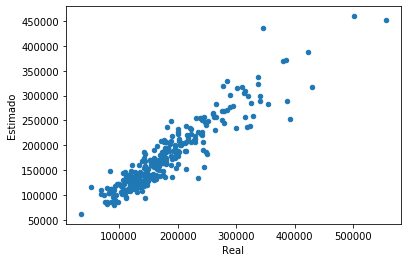

In [53]:
data = {
    "Real": pd.DataFrame(scaler.inverse_transform(df_test[numeric_features]), columns=numeric_features)["SalePrice"],
    "Estimado": pd.DataFrame(
        scaler.inverse_transform(
            df_test.assign(
                SalePrice=nnr.predict(df_test.drop("SalePrice", axis=1))
            )[numeric_features]), columns=numeric_features)["SalePrice"]
}
pd.DataFrame(data=data).plot.scatter(x="Real", y="Estimado")